In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.spatial as sp
import matplotlib as mpl

from helpers.helper import *

%matplotlib inline

# Load Employment Data

In [11]:
fp = '../../../data/databases/db15/Skills.txt'
X = load_skills(fp).replace(np.nan, 0.0)
X['O*NET-SOC Code'] = X['O*NET-SOC Code'].apply(lambda x: str(x[:-3]))

# delete duplicate data
X = X.drop_duplicates(subset = 'O*NET-SOC Code')

numbers = pd.read_csv('../../../data/education/employment_numbers.csv')
numbers = numbers.rename(columns = {'code': "O*NET-SOC Code"})

def clean_number(element):
    return float(str(element).replace(',',''))

numbers.e2014 = numbers.e2014.apply(clean_number)

X = X.merge(numbers, on = 'O*NET-SOC Code', how = 'inner')

# Divide codes from data

#### With option to find high-employment subsets

In [12]:
def get_data(X, subset = False, threshold = 0.00666666):
    if subset:
        total_emp = 150539.90
        subset_X = X[X.e2014 / total_emp >= threshold]
        X = subset_X
    codes, weights, title, X = X['O*NET-SOC Code'], X['e2014'], X.title, X.drop(['O*NET-SOC Code', 'e2014', 'title', 'Unnamed: 3'], axis = 1)
    return codes, weights, title, X

codes, weights, titles, X_matrix = get_data(X, subset = False)

# Add Weights

In [13]:
dists = sp.distance.squareform(sp.distance.pdist(X_matrix))

In [14]:
dists

array([[  0.        ,   6.68261925,   5.52246322, ...,  15.22675277,
         17.14086929,  13.11334435],
       [  6.68261925,   0.        ,   3.10396521, ...,   9.4963572 ,
         11.43110668,   7.75711286],
       [  5.52246322,   3.10396521,   0.        , ...,  10.86476875,
         12.75235664,   9.32074031],
       ..., 
       [ 15.22675277,   9.4963572 ,  10.86476875, ...,   0.        ,
          3.60469139,   4.47915171],
       [ 17.14086929,  11.43110668,  12.75235664, ...,   3.60469139,
          0.        ,   6.03778105],
       [ 13.11334435,   7.75711286,   9.32074031, ...,   4.47915171,
          6.03778105,   0.        ]])

# Find Groupings

In [25]:
import Pycluster as pc
dm = pc.distancematrix(np.array(X_matrix), dist = 'e')
solution, score, something = pc.kmedoids(dm, nclusters = 70, npass = 1000)
medoids = codes[solution].unique()
groupings = numbers[numbers['O*NET-SOC Code'].isin(medoids)]

In [26]:
groupings.e2014.sum()

14665.2

In [27]:
groupings

,O*NET-SOC Code,e2014,title,Unnamed: 3
11,11-2031,65.8,Public relations and fundraising managers,NaN
30,11-9041,182.1,Architectural and engineering managers,NaN
51,13-1032,15.5,"Insurance appraisers, auto damage",NaN
64,13-1161,495.5,Market research analysts and marketing special...,NaN
72,13-2051,277.6,Financial analysts,NaN
80,13-2081,67.9,"Tax examiners and collectors, and revenue agents",NaN
88,15-1122,82.9,Information security analysts,NaN
116,17-1021,12.3,Cartographers and photogrammetrists,NaN
133,17-2131,25.3,Materials engineers,NaN
147,17-3022,74.0,Civil engineering technicians,NaN


# KMedoids Algorithm – Github Code

In [125]:
import numpy as np
import random

def cluster(distances, k=3):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

In [175]:
ss_Skills = Skills[Skills.e2014 > 50]
codes = ss_Skills['O*NET-SOC Code']
e2014 = ss_Skills.e2014
X = ss_Skills.drop(['O*NET-SOC Code', 'e2014'], axis = 1)
dists = sp.distance.squareform(sp.distance.pdist(X))
result = cluster(dists, 70)
assignments, medoids = result
in_codes = codes.iloc[medoids]

In [179]:
for e in emp_figs[emp_figs['O*NET-SOC Code'].isin(in_codes)].c:
    print e, '\n'

Chief executives 

Transportation, storage, and distribution managers 

Education administrators, postsecondary 

Managers, all other 

Wholesale and retail buyers, except farm products 

Labor relations specialists 

Insurance underwriters 

Web developers 

Computer network architects 

Architects, except landscape and naval 

Civil engineering technicians 

Substance abuse and behavioral disorder counselors 

Mental health and substance abuse social workers 

Social and human service assistants 

Lawyers 

Business teachers, postsecondary 

Health specialties teachers, postsecondary 

Vocational education teachers, postsecondary 

Career/technical education teachers, secondary school 

Special education teachers, middle school 

Teacher assistants 

Art directors 

Merchandise displayers and window trimmers 

Actors 

Coaches and scouts 

Musicians and singers 

Internists, general 

Health diagnosing and treating practitioners, all other 

Diagnostic medical sonographers 

Pharmacy

# My Implementation

In [226]:
class Point():
    def __init__(self, x, weight = None, code = None):
        self.x = x
        self.weight = weight
        self.cluster = None
        self.code = code

class Cluster():
    def __init__(self, medoid, label):
        self.medoid = medoid
        self.label = label
        self.points = []
        self.distances = []
        self.historical_distance_sum = []

class KMedoids():
    def __init__(self, N, transform = None, max_iters = float('inf'), threshold_change = -float('inf'), print_iter = True):
        self.N = N # number of clusters
        self.M = [] # current medoids
        self.O = [] # current non-medoids
        self.clusters = []
        self.updated_clusters = []
        self.X = None
        self.weights = None
        self.n_points = None
        self.transform = lambda x: x
        self.max_iters = max_iters
        self.threshold_change = threshold_change
        self.num_changes = float('inf')
        self.print_iter = print_iter
        self.distsum = []
        self.iter_num = None
        
    def fit(self, X, weights, codes):
        self.__init__(self.N, self.transform, self.max_iters, self.threshold_change)
        # check data type
        if isinstance(X, np.ndarray):
            self.X = X
        else:
            self.X = np.array(X)

        self.n_points = self.X.shape[0]
        self.weights = np.array(weights)
        self.codes = np.array(codes)
        self._initialize_X()
        self._initialize_medoids()
        changed = True
        self.iter_num = 0
        while changed and self.iter_num < self.max_iters and self.num_changes > self.threshold_change:
            self.iter_num += 1
            if self.print_iter:
                print self.iter_num
            self._reset_clusters()
            self._assign_points()
            changed = self._update_medoids()
            self._create_self_O()
            self._update_costs()
        return self.clusters

    def _initialize_X(self):
        for point, weight, code in zip(self.X, self.weights, self.codes):
            self.O.append(Point(point, weight, code))

    def _initialize_medoids(self):
        indices = np.random.randint(0, self.n_points, self.N)
        for i in indices:
            self.clusters.append(Cluster(self.O[i], i))
        self.O = np.delete(self.O, indices, axis = 0)

    def _reset_clusters(self):
        for cluster in self.clusters:
            cluster.points, cluster.distances = [], []

    def _assign_points(self):
        for point in self.O:
            
            target_distance = float('inf')
            optimal_cluster = None
            for i, cluster in enumerate(self.clusters):
                weighted_distance = self._calc_distance(point, cluster)
                if weighted_distance < target_distance:
                    target_distance = weighted_distance
                    optimal_cluster = i
            self.clusters[optimal_cluster].points.append(point)
            self.clusters[optimal_cluster].distances.append(target_distance)
            
    def _calc_distance(self, point, cluster):
        # calcs distances between point and cluster medioid, returns 
        def euclidean_distance(u, v):
            return np.sqrt(np.sum((u - v)**2))

        distance = euclidean_distance(point.x, cluster.medoid.x)
        weighted_distance = self.transform(point.weight) * distance

        return weighted_distance

    def _update_medoids(self):
        changed = False
        new_clusters = []
        total_changed = 0
        for cluster in self.clusters:
            optimal_cluster = cluster
            target_cost = sum(cluster.distances)
            for some_point in cluster.points:
                new_cluster = cluster
                new_cluster.points.append(new_cluster.medoid)
                new_cluster.points.remove(some_point)
                new_cluster.medoid = some_point
                total_cost = self._calc_cluster_cost(new_cluster.medoid, new_cluster)
                if total_cost < target_cost:
                    target_cost = total_cost
                    optimal_cluster = new_cluster
                    changed = True
                    total_changed += 1
            optimal_cluster.historical_distance_sum.append(np.array((self.iter_num, target_cost)))
            new_clusters.append(optimal_cluster)
        self.clusters = new_clusters
        self.num_changes = total_changed
        if not changed:
            return False
        else:
            return True
        
    def _create_self_O(self):
        self.O = []
        for cluster in self.clusters:
            self.O += cluster.points
            
    def _update_costs(self):
        self.distsum.append((self.iter_num, sum(map(lambda x: sum(x.distances), self.clusters))))

    def _calc_cluster_cost(self, medoid, cluster):
        return sum(map(lambda x: self._calc_distance(x, cluster), cluster.points))

In [227]:
def agg_points(clusters, plot = False):
    all_points = np.empty((1,2))
    colours = []
    for c in clusters:
        for point in c.points:
            all_points = np.vstack((all_points, point.x[np.newaxis, :]))
        all_points = np.vstack((all_points, c.medoid.x[np.newaxis,:]))
        colours += [c.label for i in range(len(c.points) + 1)]

    x, y, c = all_points[1:,0], all_points[1:,1], np.array(colours)
    if plot:
        
        def colourmap_ints(num_list, ordered = False, convert = False):
            uniques = np.unique(num_list)
            if ordered:
                colours = {str(v): i for (i, v) in enumerate(uniques)}
                if convert:
                    return [colours[str(c)] for c in num_list]
            else:
                colours = np.random.permutation(range(len(uniques)))
            return colours
        
        n_points = len(x)
        n_clusters = len(np.unique(c))
        colour_ints = colourmap_ints(c, True, True)
        hot = sns.plt.get_cmap('hot')
        cNorm  = mpl.colors.Normalize(vmin=0, vmax=n_clusters)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=hot)
        colours = [scalarMap.to_rgba(i) for i in colour_ints]
        
        # setup the plot
        fig, ax = sns.plt.subplots(1,1, figsize=(10,10))
        ax.scatter(x,y,s=15, c = colours)

        
    else:
        return x, y, c

# Testing

In [228]:
def create_test_data(nrows, ncols = 2):
    M = np.random.rand(nrows, ncols)
    weights = np.random.rand(nrows, 1)
    code = np.random.rand(nrows, 1)
    return M, weights, code

X, W, C = create_test_data(100)
W = W**3

In [229]:
km = KMedoids(5, lambda x: 1./np.log(x), 1000)
clusters = km.fit(X, W, C)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


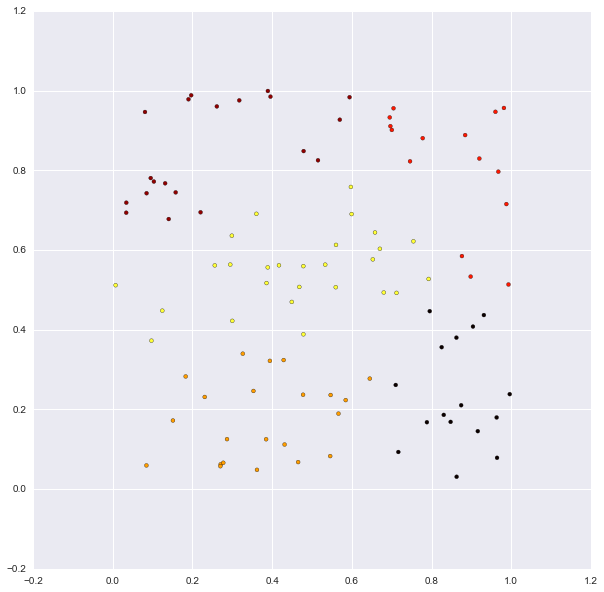

In [230]:
agg_points(clusters, True)

In [231]:
clusters[0].historical_distance_sum

[array([ 1.        ,  1.24984852]),
 array([ 2.        ,  1.31056973]),
 array([ 3.       ,  0.3500113]),
 array([ 4.        ,  0.33693681]),
 array([ 5.        ,  0.03756838]),
 array([  6.00000000e+00,   4.90666260e-03]),
 array([ 7.        ,  0.36681141]),
 array([ 8.        ,  0.12832678]),
 array([ 9.        ,  0.87446522]),
 array([ 10.        ,   0.29735255]),
 array([ 11.        ,   1.07626278]),
 array([ 12.        ,   0.46193345]),
 array([ 13.        ,   1.10785215]),
 array([ 14.        ,   0.20030759]),
 array([ 15.        ,   0.43452641]),
 array([ 16.        ,   0.72917785]),
 array([ 17.        ,   0.19441185]),
 array([ 18.        ,   0.85014394]),
 array([ 19.        ,   0.97820904]),
 array([ 20.        ,   0.71556546]),
 array([ 21.        ,   1.75976151]),
 array([ 22.        ,   1.07415005]),
 array([ 23.        ,   0.82914967]),
 array([ 24.        ,   0.62939316]),
 array([ 25.        ,   0.45677541]),
 array([ 26.        ,   0.67086752]),
 array([ 27.        , 

# Application

In [111]:
fp = '../../../data/databases/db15/Skills.txt'
Skills = load_skills(fp)
Skills['O*NET-SOC Code'] = Skills['O*NET-SOC Code'].apply(lambda x: str(x)[:-3])
Skills = Skills.replace(np.nan, 0)
Skills = Skills.drop_duplicates(subset = 'O*NET-SOC Code')

In [112]:
emp_figs = pd.read_csv('../../../data/education/employment_numbers.csv').iloc[:,:-1]
emp_figs.columns = ['O*NET-SOC Code', 'e2014', 'c']
Skills = Skills.merge(emp_figs[['O*NET-SOC Code', 'e2014']], on = 'O*NET-SOC Code', how = 'inner')
Skills.e2014 = Skills.e2014.apply(lambda x: float(str(x).replace(',','')))

In [113]:
      150000*0.10 / 30

500.0

In [114]:
subset_Skills = Skills[Skills.e2014 > 100]
subset_Skills.shape

(278, 37)

In [115]:
weights = subset_Skills.pop('e2014')
ones_weights = np.ones_like(weights)
codes = subset_Skills.pop('O*NET-SOC Code')

In [116]:
km = KMedoids(70, transform = lambda x: 1/np.log(x), max_iters = 4000, threshold_change = 7)

In [117]:
clusters = km.fit(np.array(subset_Skills), ones_weights, codes)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [238]:
array = np.vstack(clusters[0].historical_distance_sum)
x, y = array[:,0], array[:,1]


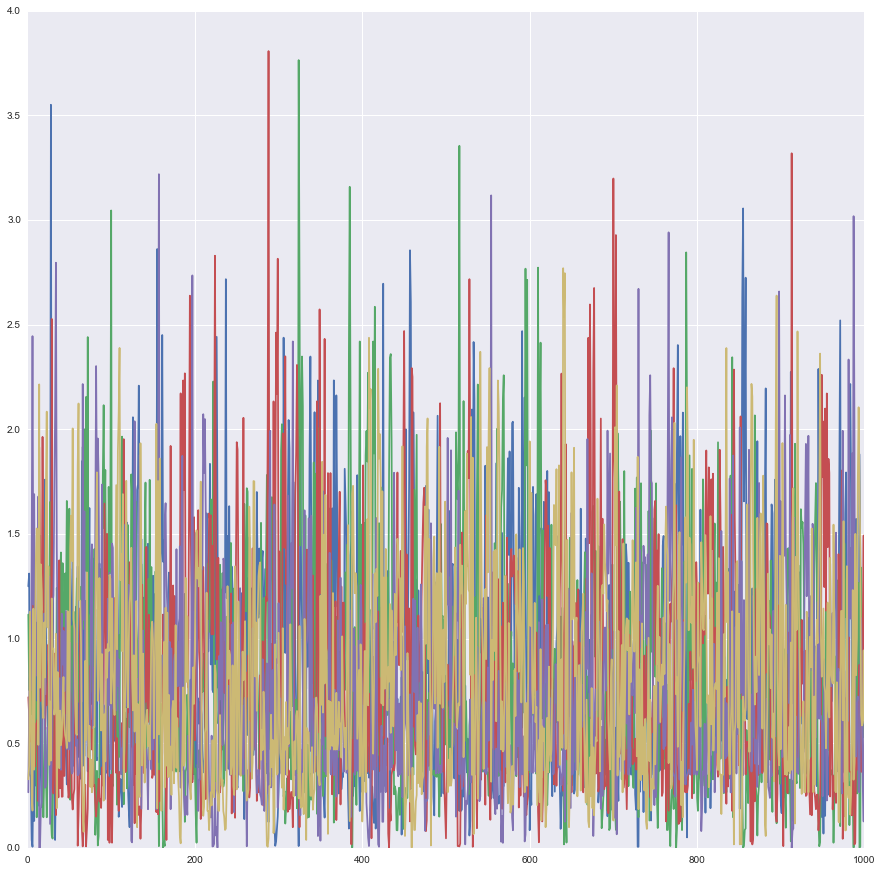

In [246]:
sns.plt.figure(figsize=(15,15))
for c in clusters:
    arr = np.vstack(c.historical_distance_sum)
    x, y = arr[:,0], arr[:,1]
    sns.plt.plot(x, y)

In [232]:
x, y = np.array(km.distsum)[:,0], np.array(km.distsum)[:,1]

In [119]:
codes = [c.medoid.code for c in clusters]

In [121]:
Skills[Skills['O*NET-SOC Code'].isin(codes)].e2014

0       343.4
7       348.5
18      240.0
19      175.1
21      182.1
26      333.0
39      260.3
45      758.0
52     1332.7
64      145.2
68      328.6
69      718.4
71      148.5
74      146.2
75      585.9
91      281.4
93      178.4
100     277.5
104     136.9
120     114.1
165     305.2
182     106.8
201     210.4
214     159.2
219     159.4
225     198.1
236     101.8
248     261.6
253     122.6
255     250.6
        ...  
338    1492.1
344     318.8
345     591.3
363     680.0
368    1095.4
376     417.6
380     873.9
384    2465.1
427    1537.8
435     466.1
446     237.9
451     350.4
470     195.9
487     215.5
489    2457.0
495     104.9
532     360.5
569     131.6
580     119.9
596     292.0
617     129.0
666     153.9
707     378.4
720     419.2
721     236.2
723     173.1
724     199.7
734    1797.7
748     135.6
760     346.9
Name: e2014, dtype: float64

In [123]:
Skills[Skills['O*NET-SOC Code'].isin(codes)].e2014.sum()

29032.000000000004

In [124]:
for i in emp_figs[emp_figs['O*NET-SOC Code'].isin(codes)].c:
    print i, '\n'

Chief executives 

Computer and information systems managers 

Education administrators, elementary and secondary school 

Education administrators, postsecondary 

Architectural and engineering managers 

Medical and health services managers 

Compliance officers 

Management analysts 

Accountants and auditors 

Financial specialists, all other 

Computer programmers 

Software developers, applications 

Web developers 

Computer network architects 

Computer user support specialists 

Civil engineers 

Electrical engineers 

Mechanical engineers 

Engineers, all other 

Biological scientists 

Child, family, and school social workers 

Business teachers, postsecondary 

Health specialties teachers, postsecondary 

Graduate teaching assistants 

Kindergarten teachers, except special education 

Special education teachers, kindergarten and elementary school 

Library technicians 

Graphic designers 

Producers and directors 

Coaches and scouts 

Public relations specialists 

Editors

In [ ]:

Chief executives 

Computer and information systems managers 

Financial managers 

Construction managers 

Food service managers 

Property, real estate, and community association managers 

Managers, all other 

Compliance officers 

Human resources specialists 

Market research analysts and marketing specialists 

Business operations specialists, all other 

Accountants and auditors 

Loan officers 

Software developers, applications 

Software developers, systems software 

Network and computer systems administrators 

Computer occupations, all other 

Civil engineers 

Educational, guidance, school, and vocational counselors 

Child, family, and school social workers 

Social and human service assistants 

Clergy 

Preschool teachers, except special education 

Secondary school teachers, except special and career/technical education 

Self-enrichment education teachers 

Coaches and scouts 

Public relations specialists 

Pharmacists 

Physicians and surgeons, all other 

Physical therapists 

Licensed practical and licensed vocational nurses 

Dental assistants 

Firefighters 

Correctional officers and jailers 

Police and sheriff's patrol officers 

Security guards 

First-line supervisors of food preparation and serving workers 

Cooks, restaurant 

Food preparation workers 

Insurance sales agents 

Sales representatives, services, all other 

Sales representatives, wholesale and manufacturing, technical and scientific products 

Telemarketers 

Bill and account collectors 

Billing and posting clerks 

Customer service representatives 

Postal service mail carriers 

Production, planning, and expediting clerks 

Stock clerks and order fillers 

Secretaries and administrative assistants, except legal, medical, and executive 

Office clerks, general 

Farmworkers and laborers, crop, nursery, and greenhouse 

Carpenters 

Construction laborers 

Operating engineers and other construction equipment operators 

Plumbers, pipefitters, and steamfitters 

Automotive service technicians and mechanics 

Heating, air conditioning, and refrigeration mechanics and installers 

Maintenance and repair workers, general 

First-line supervisors of production and operating workers 

Machinists 

Inspectors, testers, sorters, samplers, and weighers 

Packaging and filling machine operators and tenders 

Helpers--production workers 

Bus drivers, school or special client 

Heavy and tractor-trailer truck drivers 

Light truck or delivery services drivers 

Taxi drivers and chauffeurs 

Cleaners of vehicles and equipment 